In [1]:
from adv_train.utils.logger import Database, RecordState
from adv_train.dynamic import Attacker
from adv_train.model import MnistModel
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd

In [2]:
PATH = "/checkpoint/hberard/AdversarialTraining/logs/mnist_sweep_fgsm_2/"
db = Database(PATH)

In [63]:
_df = db.extract_to_df()

In [101]:
df = _df[
        #(results['eps_iter'] > 0.006) & (results['lr'] > 0.003) & (results['type'] == MnistModel.MODEL_A) &
        (((_df["attacker_type"] == Attacker.LANGEVIN) & (_df["eps_iter"] > 0.01) & (_df["lr"] > 0.006)) #|
        #  ((_df["attacker_type"] == Attacker.PGD_40) & (_df["eps_iter"] > 0.008) & (_df["lr"] < 0.06))
        )]
print(len(df))

58


<AxesSubplot:xlabel='fgsm', ylabel='Density'>

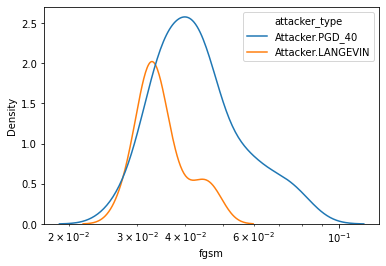

In [62]:
sns.kdeplot(data=df, hue="attacker_type", x="fgsm", clip=(-5,0), log_scale=True)

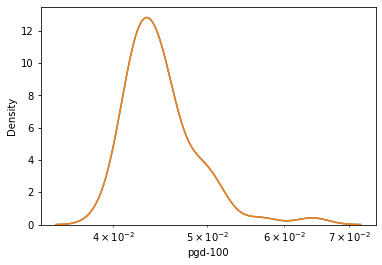

In [104]:
ax = sns.kdeplot(data=df[df["noise_scale"].between(0.001, 1.)], x="pgd-100", clip=(-5,0), log_scale=True)
ax = sns.kdeplot(data=df[df["noise_scale"].between(0.001, 1.)], x="pgd-100", clip=(-5,0), log_scale=True, ax=ax)

<AxesSubplot:xlabel='pgd-100', ylabel='Density'>

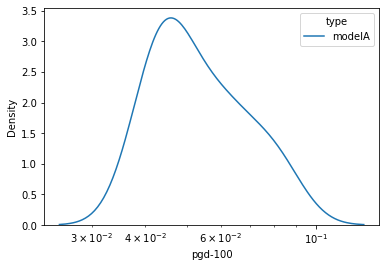

In [490]:
sns.kdeplot(data=df[df["attacker_type"]==Attacker.PGD_40], x="pgd-100", hue="type", clip=(-5,0), log_scale=True)

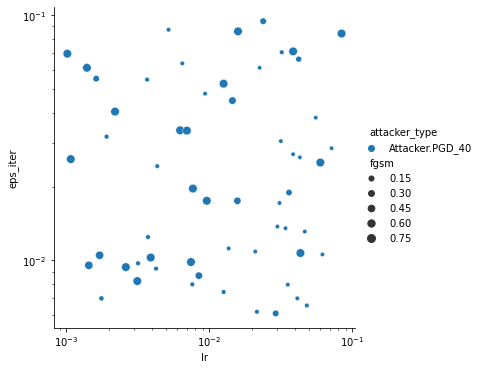

In [265]:
sns.relplot(x="lr", y="eps_iter", size="fgsm", hue="attacker_type", data=df)
plt.xscale("log")
plt.yscale("log")

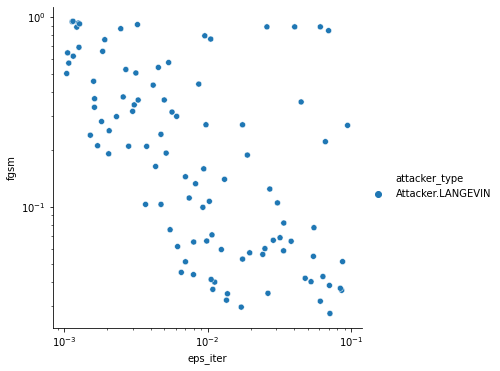

In [356]:
sns.relplot(x="eps_iter", y="fgsm", hue="attacker_type", data=df)
plt.xscale("log")
plt.yscale("log")

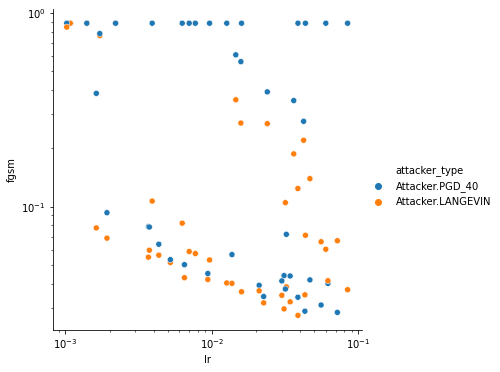

In [109]:
sns.relplot(x="lr", y="fgsm", hue="attacker_type", data=df)
plt.xscale("log")
plt.yscale("log")

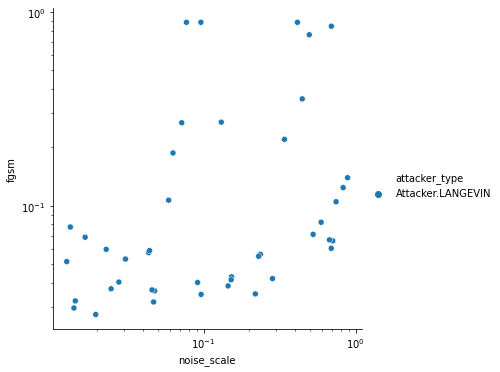

In [111]:
sns.relplot(x="noise_scale", y="fgsm", hue="attacker_type", data=df[df["attacker_type"]==Attacker.LANGEVIN])
plt.xscale("log")
plt.yscale("log")